## Data Ingestion

In [20]:
import os
import sys
import copy
import time
import random
import pyspark

from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc, size, max, abs, split, col, unix_timestamp, round
from pyspark.sql.window import Window
import pyspark.sql.functions as F

import matplotlib.pyplot as plt
import numpy as np

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer

In [5]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Predictive Maintenance") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
    return spark

spark = init_spark()

In [29]:
filename = "..\data\machines.csv"
machines = spark.read.csv(filename, sep=',', header=True)

print(machines.count())
machines.show()

100
+---------+------+---+
|machineID| model|age|
+---------+------+---+
|        1|model3| 18|
|        2|model4|  7|
|        3|model3|  8|
|        4|model3|  7|
|        5|model3|  2|
|        6|model3|  7|
|        7|model3| 20|
|        8|model3| 16|
|        9|model4|  7|
|       10|model3| 10|
|       11|model2|  6|
|       12|model3|  9|
|       13|model1| 15|
|       14|model3|  1|
|       15|model3| 14|
|       16|model1|  3|
|       17|model1| 14|
|       18|model3| 15|
|       19|model3| 17|
|       20|model2| 16|
+---------+------+---+
only showing top 20 rows



In [9]:
filename = "..\data\errors.csv"
errors = spark.read.csv(filename, sep=',', header=True)

print(errors.count())
errors.show()

3919
+--------------------+---------+-------+
|            datetime|machineID|errorID|
+--------------------+---------+-------+
| 1/3/2015 7:00:00 AM|        1| error1|
| 1/3/2015 8:00:00 PM|        1| error3|
| 1/4/2015 6:00:00 AM|        1| error5|
|1/10/2015 3:00:00 PM|        1| error4|
|1/22/2015 10:00:0...|        1| error4|
|1/25/2015 3:00:00 PM|        1| error4|
|1/27/2015 4:00:00 AM|        1| error1|
|3/3/2015 10:00:00 PM|        1| error2|
| 3/5/2015 6:00:00 AM|        1| error1|
|3/20/2015 6:00:00 PM|        1| error1|
|3/26/2015 1:00:00 AM|        1| error2|
|3/31/2015 11:00:0...|        1| error1|
|4/19/2015 6:00:00 AM|        1| error2|
|4/19/2015 6:00:00 AM|        1| error3|
|4/29/2015 7:00:00 PM|        1| error4|
|5/4/2015 11:00:00 PM|        1| error2|
|5/12/2015 9:00:00 AM|        1| error1|
|5/21/2015 7:00:00 AM|        1| error4|
|5/24/2015 2:00:00 AM|        1| error3|
|5/25/2015 5:00:00 AM|        1| error1|
+--------------------+---------+-------+
only showin

In [7]:
filename = "..\data\\failures.csv"
failures  = spark.read.csv(filename, sep=',', header=True)

print(failures.count())
failures.show()

719
+--------------------+---------+
|            datetime|machineID|
+--------------------+---------+
| 1/5/2015 6:00:00 AM|        1|
| 3/6/2015 6:00:00 AM|        1|
|4/20/2015 6:00:00 AM|        1|
|6/19/2015 6:00:00 AM|        1|
| 9/2/2015 6:00:00 AM|        1|
|10/17/2015 6:00:0...|        1|
|12/16/2015 6:00:0...|        1|
|3/19/2015 6:00:00 AM|        2|
|4/18/2015 6:00:00 AM|        2|
|12/29/2015 6:00:0...|        2|
| 1/7/2015 6:00:00 AM|        3|
| 2/6/2015 6:00:00 AM|        3|
|7/21/2015 6:00:00 AM|        3|
|10/4/2015 6:00:00 AM|        3|
|12/3/2015 6:00:00 AM|        3|
|1/17/2015 6:00:00 AM|        4|
|2/16/2015 6:00:00 AM|        4|
| 4/2/2015 6:00:00 AM|        4|
|7/16/2015 6:00:00 AM|        4|
|8/30/2015 6:00:00 AM|        4|
+--------------------+---------+
only showing top 20 rows



In [56]:
filename = "..\data\\telemetry.csv"
telemetry = spark.read.csv(filename, sep=',', header=True)

print(telemetry.count())
telemetry.show()
telemetry.limit(25).toPandas().head()

876100
+-------------------+---------+----------------+----------------+----------------+----------------+
|           datetime|machineID|            volt|          rotate|        pressure|       vibration|
+-------------------+---------+----------------+----------------+----------------+----------------+
|2015-01-01 06:00:00|        1|176.217853015625|418.504078221616|113.077935462083|45.0876857639276|
|2015-01-01 07:00:00|        1| 162.87922289706|402.747489565395|95.4605253823187|43.4139726834815|
|2015-01-01 08:00:00|        1|170.989902405567|527.349825452291|75.2379048586662|34.1788471214451|
|2015-01-01 09:00:00|        1|162.462833264092|346.149335043074|109.248561276504|41.1221440884256|
|2015-01-01 10:00:00|        1| 157.61002119306|435.376873016938|111.886648210168|25.9905109982024|
|2015-01-01 11:00:00|        1|172.504839196295|430.323362106675|95.9270416939636|35.6550173268837|
|2015-01-01 12:00:00|        1|156.556030606329|499.071623068962|111.755684290096|42.75391969

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853015625,418.504078221616,113.077935462083,45.0876857639276
1,2015-01-01 07:00:00,1,162.87922289706,402.747489565395,95.4605253823187,43.4139726834815
2,2015-01-01 08:00:00,1,170.989902405567,527.349825452291,75.2379048586662,34.1788471214451
3,2015-01-01 09:00:00,1,162.462833264092,346.149335043074,109.248561276504,41.1221440884256
4,2015-01-01 10:00:00,1,157.61002119306,435.376873016938,111.886648210168,25.9905109982024


In [1]:
def plot_ts(ax, values, times, label=None, color='blue', xmin=None, xmax=None, ymin=None, ymax=None, anomalies=None):
    step = 700
    if xmin is not None:
        assert(xmax is not None)
        ax.set(xlim=(xmin, xmax))
    if ymin is not None:
        assert(ymax is not None)
        ax.set(ylim=(ymin, ymax))
    if xmin is None:
        ax.set_xticks([i for i in range(len(values)) if i % step == 0])
        ax.set_xticklabels([times[i] for i in range(len(values)) if i % step == 0])
    ax.plot(values, label=label, color=color)
    if anomalies is not None:
        x, y = anomalies
        ax.scatter(x, y, label='Anomalies', color='red')
    if label is not None:
        ax.legend()

TypeError: object of type 'Column' has no len()

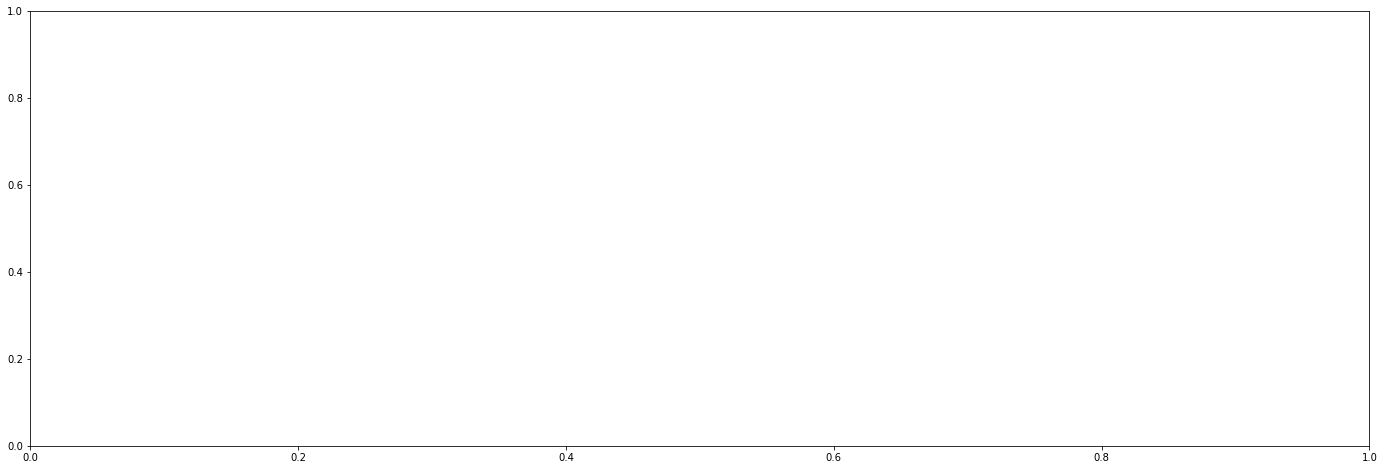

In [10]:
fs = (24, 8)
fig, ax = plt.subplots(1, 1, figsize=fs)

telemetry_values = telemetry['volt']
telemetry_dates = telemetry['datetime']
plot_ts(ax, telemetry_values, telemetry_dates, label="volt", color='green')

# Time Window

In [57]:
# rolling mean and standard deviation
# Temporary storage for rolling means
tel_mean = telemetry

# Engineer features
rolling_features = ['volt','rotate', 'pressure', 'vibration']
      
# n hours = n * 3600 seconds  
time_val = 12 * 3600

# Choose the time_val hour timestamps to align the data
# dt_truncated looks at the column named "datetime" in the current data set.
# remember that Spark is lazy... this doesn't execute until it is in a withColumn statement.
dt_truncated = ((round(unix_timestamp(col("datetime")) / time_val) * time_val).cast("timestamp"))

In [59]:
lags = [12, 24, 36] #in hours

# align the data
for lag_n in lags:
    wSpec = Window.partitionBy('machineID').orderBy('datetime').rowsBetween(1-lag_n, 0)
    for col_name in rolling_features:
        tel_mean = tel_mean.withColumn(col_name+'_rollingmean_'+str(lag_n), 
                                       F.avg(col(col_name)).over(wSpec))
        tel_mean = tel_mean.withColumn(col_name+'_rollingstd_'+str(lag_n), 
                                       F.stddev(col(col_name)).over(wSpec))

# Calculate lag values...
telemetry_feat = (tel_mean.withColumn("dt_truncated", dt_truncated)
                  .drop('volt', 'rotate', 'pressure', 'vibration')
                  .fillna(0)
                  .groupBy("machineID","dt_truncated")
                  .agg(F.mean('volt_rollingmean_12').alias('volt_rollingmean_12'),
                       F.mean('rotate_rollingmean_12').alias('rotate_rollingmean_12'), 
                       F.mean('pressure_rollingmean_12').alias('pressure_rollingmean_12'), 
                       F.mean('vibration_rollingmean_12').alias('vibration_rollingmean_12'), 
                       F.mean('volt_rollingmean_24').alias('volt_rollingmean_24'),
                       F.mean('rotate_rollingmean_24').alias('rotate_rollingmean_24'), 
                       F.mean('pressure_rollingmean_24').alias('pressure_rollingmean_24'), 
                       F.mean('vibration_rollingmean_24').alias('vibration_rollingmean_24'),
                       F.mean('volt_rollingmean_36').alias('volt_rollingmean_36'),
                       F.mean('vibration_rollingmean_36').alias('vibration_rollingmean_36'),
                       F.mean('rotate_rollingmean_36').alias('rotate_rollingmean_36'), 
                       F.mean('pressure_rollingmean_36').alias('pressure_rollingmean_36'), 
                       F.stddev('volt_rollingstd_12').alias('volt_rollingstd_12'),
                       F.stddev('rotate_rollingstd_12').alias('rotate_rollingstd_12'), 
                       F.stddev('pressure_rollingstd_12').alias('pressure_rollingstd_12'), 
                       F.stddev('vibration_rollingstd_12').alias('vibration_rollingstd_12'), 
                       F.stddev('volt_rollingstd_24').alias('volt_rollingstd_24'),
                       F.stddev('rotate_rollingstd_24').alias('rotate_rollingstd_24'), 
                       F.stddev('pressure_rollingstd_24').alias('pressure_rollingstd_24'), 
                       F.stddev('vibration_rollingstd_24').alias('vibration_rollingstd_24'),
                       F.stddev('volt_rollingstd_36').alias('volt_rollingstd_36'),
                       F.stddev('rotate_rollingstd_36').alias('rotate_rollingstd_36'), 
                       F.stddev('pressure_rollingstd_36').alias('pressure_rollingstd_36'), 
                       F.stddev('vibration_rollingstd_36').alias('vibration_rollingstd_36'), ))

print(tel_mean.count())
print(telemetry_feat.count())
#telemetry_feat.where((col("machineID") == 1)).limit(10).toPandas().head(10)

876100
73100


In [58]:
test = tel_mean.withColumn("dt_truncated", dt_truncated).drop('volt', 'rotate', 'pressure', 'vibration').show()

+-------------------+---------+-------------------+
|           datetime|machineID|       dt_truncated|
+-------------------+---------+-------------------+
|2015-01-01 06:00:00|        1|2015-01-01 07:00:00|
|2015-01-01 07:00:00|        1|2015-01-01 07:00:00|
|2015-01-01 08:00:00|        1|2015-01-01 07:00:00|
|2015-01-01 09:00:00|        1|2015-01-01 07:00:00|
|2015-01-01 10:00:00|        1|2015-01-01 07:00:00|
|2015-01-01 11:00:00|        1|2015-01-01 07:00:00|
|2015-01-01 12:00:00|        1|2015-01-01 07:00:00|
|2015-01-01 13:00:00|        1|2015-01-01 19:00:00|
|2015-01-01 14:00:00|        1|2015-01-01 19:00:00|
|2015-01-01 15:00:00|        1|2015-01-01 19:00:00|
|2015-01-01 16:00:00|        1|2015-01-01 19:00:00|
|2015-01-01 17:00:00|        1|2015-01-01 19:00:00|
|2015-01-01 18:00:00|        1|2015-01-01 19:00:00|
|2015-01-01 19:00:00|        1|2015-01-01 19:00:00|
|2015-01-01 20:00:00|        1|2015-01-01 19:00:00|
|2015-01-01 21:00:00|        1|2015-01-01 19:00:00|
|2015-01-01 